In [2]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
from src.ModelClasses import Geometry, CellType, Water, Solute, Grid, BoundSolute
from src.ModelSetup import Nondimensionalise, CalculateTimestep
from src.TimestepManager import Timestep
from tqdm import tqdm
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

In [3]:
grid_sizes = [4000, 3000, 2750, 2500, 2250, 2000, 1750, 1500]

cell_outputs = []
cell_cons_errors = []

# Loop over grid sizes

for grid_size in grid_sizes:
    nx = grid_size

    # --------------------------------------  MODEL SETUP

    # Input model geometry and (dimensional) parameters

    geometry = Geometry(T = 1e5, L = 3e-3)

    cell = CellType(diffusion_rate = 1e-14, initial_volume_fraction = 0.05, chemotaxis_strength=1.36, chemotaxis_strength_bound=42.4, matrix_drag=9.89e9, matrix_traction=0.0, contact_inhibition=0.0, aggregation_strength=0)

    water = Water(matrix_volume_fraction=0.03, matrix_drag=5e7)

    solute = Solute(diffusion_rate = 1e-11, initial_solute_concentration = 0, production_rate=8.74e-11, uptake_rate=0, degradation_rate=8.21e-4, binding_rate=1.5e-3)

    bound_solute = BoundSolute(initial_solute_concentration=0, unbinding_rate=3.7e-3, degradation_rate=8.21e-4)

    # Initialise grid

    grid = Grid(nx = nx, dx = 1/nx)

    # Set initial cell and water distributions

    multiplier = int(nx/250)
    np.random.seed(28) #fix noise distribution to be the same every time
    cell.distribution = cell.initial_volume_fraction + np.random.normal(0, 0.1*cell.initial_volume_fraction, 250)
    cell.distribution = np.repeat(cell.distribution, multiplier)
    water.distribution = water.available_volume_fraction - cell.distribution

    # Set initial cell velocity

    cell.velocity = np.zeros(grid.nx)

    # Set initial solute distribution

    solute.distribution = solute.uniform_solute_distribution(water, grid)

    bound_solute.distribution = bound_solute.uniform_solute_distribution(water, grid)

    # Save initial distributions

    initial_cell_distribution = cell.distribution
    initial_solute_distribution = solute.distribution

    # Nondimensionalise the input parameters

    Nondimensionalise(cell, solute, bound_solute, water, geometry, cM = 1e-9, cell_viscosity = 1e4)

    # Set fixed timestep and number of timesteps

    dt = 0.002
    Tmax = 0.2
    nsteps = int(Tmax/dt)
    print(nsteps)

    # -------------------------------- RUN THE MODEL

    cons_init = np.sum(cell.distribution)

    for t in tqdm(range(nsteps+1)):
        Timestep(cell, solute, bound_solute, water, grid, dt)

    # Calculate conservation error

    cons_final = np.sum(cell.distribution)

    print('cons_error =', (cons_final - cons_init)/cons_init)
    cell_cons_errors.append(np.abs(cons_final - cons_init)/cons_init)

    # Save average cell volume fraction

    cell_outputs.append(np.sum(cell.distribution)/(nx))

  4%|▍         | 4/101 [00:00<00:02, 39.98it/s]

100


  7%|▋         | 7/101 [00:00<00:01, 65.54it/s]

cons_error = 2.1770308125698194e-05
100


  5%|▍         | 5/101 [00:00<00:02, 46.58it/s]

cons_error = 2.8708433496402227e-05
100


  7%|▋         | 7/101 [00:00<00:01, 58.72it/s]

cons_error = 3.120861863811147e-05
100


  9%|▉         | 9/101 [00:00<00:01, 88.26it/s]

cons_error = 3.4196764841414875e-05
100


 10%|▉         | 10/101 [00:00<00:00, 94.21it/s]

cons_error = 3.7831879625656396e-05
100


 11%|█         | 11/101 [00:00<00:00, 102.84it/s]

cons_error = 4.235660843095746e-05
100


 12%|█▏        | 12/101 [00:00<00:00, 114.27it/s]

cons_error = 4.8146706610132144e-05
100


100%|██████████| 101/101 [00:00<00:00, 103.49it/s]

cons_error = 5.583638668357695e-05


In [4]:
cells_grid_error = []
spacing_list = []

for i in range(1, len(grid_sizes)):
    cells_grid_error.append(abs(cell_outputs[i] - cell_outputs[0]) / cell_outputs[0]) 
    spacing_list.append(1/grid_sizes[i])

In [5]:
mx = len(spacing_list) - 1

# make list of grid spacings for x axis
x = np.linspace(np.log(spacing_list[0]), np.log(spacing_list[mx]), 100)

# find line of gradient 2 through a particular data point 
Ynint = np.log(np.abs(cells_grid_error[2])) - 2 * np.log(spacing_list[2])
Yn = Ynint + (2 * x)

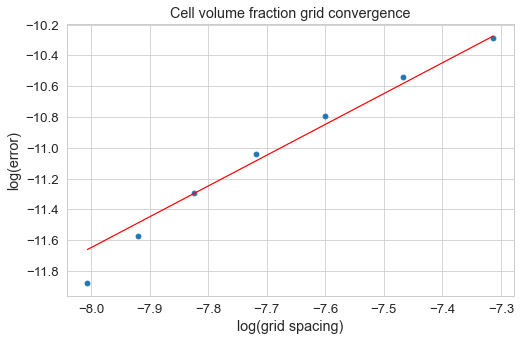

In [7]:
# plot cell volume fraction error against grid spacing 

plt.figure(figsize=(8, 5))
plt.plot(np.log(spacing_list), np.log(np.abs(cells_grid_error)), 'o')
plt.title('Cell volume fraction grid convergence')
plt.xlabel('log(grid spacing)')
plt.ylabel('log(error)')
plt.plot(x, Yn, 'r')
#plt.savefig('cell_grid_convergence.png')

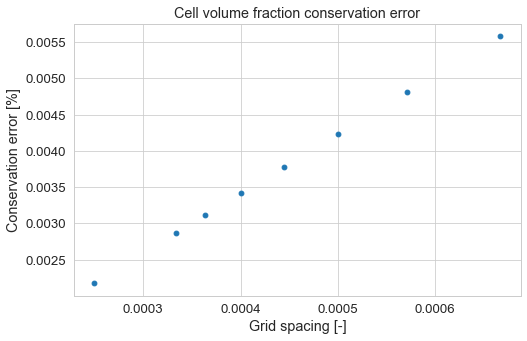

In [9]:
# plot cell_cons_errors

plt.figure(figsize=(8, 5))

spacing = [1/grid_sizes[i] for i in range(len(grid_sizes))]

plt.plot(spacing, 100*np.abs(cell_cons_errors), 'o')
plt.title('Cell volume fraction conservation error')
plt.xlabel('Grid spacing [-]')
plt.ylabel('Conservation error [%]')
#plt.savefig('cell_grid_conservation_error.png')